In [1]:
import pandas as pd
import scipy
import numpy as np
import scipy.sparse as sp
import scipy.io as spio

from scipy.stats import pearsonr

import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.collections as collections

import isolearn.io as isoio

from analyze_aparent_designed_mpra_helpers import *


<h2>Load collapsed designed MPRA data</h2>

In [2]:
#Load designed MPRA data (Collapsed over experiment replicates)
seq_dict = isoio.load('../data/prepared_data/apa_array_data/apa_array_data_master_seq')
print("n = " + str(len(seq_dict['array_df'])))
print('Avg read count (avg over barcodes) = ' + str(np.mean(seq_dict['array_df'].query("n_barcodes >= 2")['mean_total_count'])))
print('Pooled read count (pooled over barcodes) = ' + str(np.mean(seq_dict['array_df'].query("n_barcodes >= 2")['pooled_total_count'])))

#Load variant dataframe
variant_dict = isoio.load('../data/prepared_data/apa_variant_data/apa_variant_data_master_seq')
print("n (variants) = " + str(len(variant_dict['variant_df'])))

#Load predictions
model_name = 'aparent_theano_legacy_30_31_34_pasaligned'
pred_dict = isoio.load('predictions/apa_array_data_legacy/' + model_name + '_predictions_master_seq')

#Join mpra dataframes with prediction table and calculate cut probabilities
seq_df, variant_df = append_predictions(seq_dict['array_df'], seq_dict['pooled_cuts'], variant_dict['variant_df'], variant_dict['pooled_cuts_var'], variant_dict['pooled_cuts_ref'], pred_dict['array_df'], pred_dict['cut_prob'])


n = 39833
Avg read count (avg over barcodes) = 431.92676310713546
Pooled read count (pooled over barcodes) = 3656.5562880452626
n (variants) = 21734


<h2>Absolute isoform predictions of Native Human pA sites</h2>

clinvar_wt = 1085


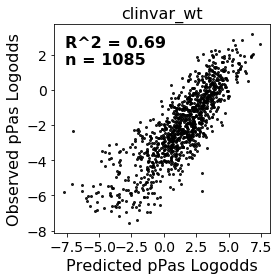

intronic_pas = 9800


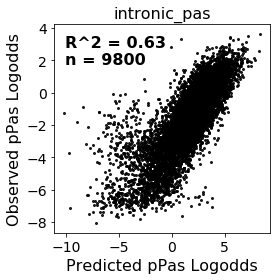

In [3]:
#Absolute native predictions, split by experiment

save_figs = False

pred_column = 'mean_logodds_pred'
true_column = 'pooled_proximal_logodds'

for experiment in ['clinvar_wt', 'intronic_pas'] :
    
    filter_query = "variant == 'wt' and mean_total_count >= 200 and n_barcodes >= 7 and experiment == '" + str(experiment) + "'"
    experiment_seq_predicted_isoform_df = seq_df.query(filter_query)
    
    logodds_true_is_nan = (np.isnan(experiment_seq_predicted_isoform_df[true_column]) | np.isinf(experiment_seq_predicted_isoform_df[true_column]))
    logodds_pred_is_nan = (np.isnan(experiment_seq_predicted_isoform_df[pred_column]) | np.isinf(experiment_seq_predicted_isoform_df[pred_column]))
    experiment_seq_predicted_isoform_df = experiment_seq_predicted_isoform_df.loc[(logodds_true_is_nan == False) & (logodds_pred_is_nan == False)]

    print(experiment + ' = ' + str(len(experiment_seq_predicted_isoform_df)))

    #Logodds proportions

    r_val, _ = pearsonr(experiment_seq_predicted_isoform_df[pred_column], experiment_seq_predicted_isoform_df[true_column])

    f = plt.figure(figsize=(4, 4))

    plt.scatter(experiment_seq_predicted_isoform_df[pred_column], experiment_seq_predicted_isoform_df[true_column], alpha=0.85, s=4, c='black')

    annot_text = 'R^2 = ' + str(round(r_val * r_val, 2))
    annot_text += '\nn = ' + str(len(experiment_seq_predicted_isoform_df))
    ax = plt.gca()
    ax.text(0.05, 0.95, annot_text, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, color='black', fontsize=16, weight="bold")
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlabel('Predicted pPas Logodds', fontsize=16)
    plt.ylabel('Observed pPas Logodds', fontsize=16)
    plt.title(experiment, fontsize=16)

    plt.tight_layout()

    if save_figs :
        plt.savefig('absolute_usage_pred_vs_true_' + experiment + '.png', transparent=True, dpi=150)
        plt.savefig('absolute_usage_pred_vs_true_' + experiment + '.eps')

    plt.show()